# Linear Regression Using LinearSVR

In this notebook, we review how to create, train, and evaluate a linearSVR regression model using the Concrete ML library, our open-source, privacy-preserving, machine learning framework based on Fully Homomorphic Encryption (FHE).

For the sake of simplicity, we will only consider a single explanatory variable, making it easy to plot its relationship with the target variable.  

In order to identify the best set of hyperparameters for the linearSVR, we perform a grid search on the following : 

* $C$: (inverse) strength of the l2 penalization
* $\epsilon$: margin for the support vectors

Please refer to Scikit-Learn documentation on [linearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) for more details

## Import libraries

In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVR as SklearnLinearSVR

from concrete.ml.sklearn.svm import LinearSVR as ConcreteLinearSVR

And some helpers for visualization.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(mse_score=None):
    label = "scikit-learn"
    if mse_score is not None:
        label += f", {'$MSE$'}={mse_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}


def get_concrete_plot_config(mse_score=None):
    label = "Concrete-ML"
    if mse_score is not None:
        label += f", {'$MSE$'}={mse_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}

## Generate a data-set

In [3]:
# Load the diabetes data-set
X, y = load_diabetes(return_X_y=True)
# Use only one feature for educational purpose
X = X[:, np.newaxis, 2]

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=23)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

We display the data-set to visualize the data distribution.

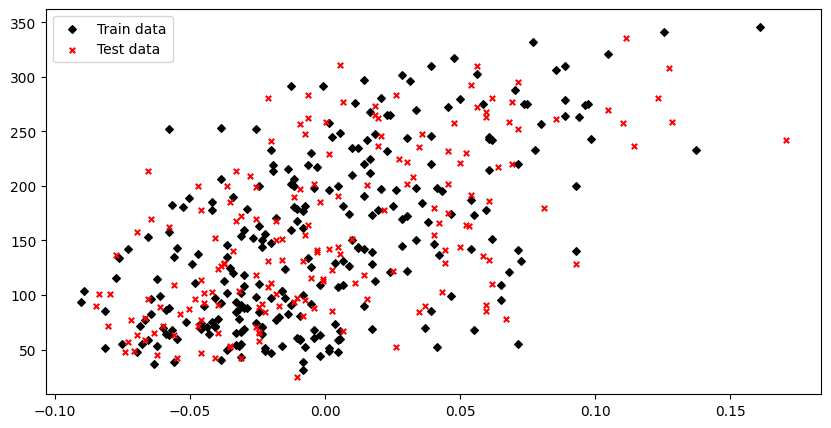

In [4]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

## Identify best set of hyperparameters

###  Sklearn LinearSVR.

Create scorer with the [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [5]:
grid_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Train the scikit-learn LinearSVR model on clear data.

A parameter grid with several values for $\epsilon$ and $C$ is used. 

In [6]:
param_grid = {
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

sklearn_rgs = SklearnLinearSVR()
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=13)

gs_sklearn = GridSearchCV(
    sklearn_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


###  Concrete ML quantized LinearSVR.

The typical development flow of a Concrete ML model is the following:

* The model is trained on clear (plaintext) data, as only FHE inference is currently supported.
* The resulting trained model is quantized using a `n_bits` parameter set by the user (see documentation [here](../built-in-models/linear.md#quantization-parameters)). This parameter can either be:
    1. a dictionary composed of `op_inputs` and `op_weights` keys. These parameters are given as integers representing the number of bits over which the associated data should be quantized.
    2. an integer, representing the number of bits over which each input and weight should be quantized. Default is 8. We try several values to test the various precisions gained for quantization. 
* The quantized model is compiled to an FHE-equivalent, following 3 steps:
    1. Create an executable operation graph.
    2. Check that the op-graph is FHE-compatible by checking the maximum bit-width needed to execute the model.
    3. Determine cryptographic parameters that will help to generate the secret keys and evaluation keys. If no parameters can be found, the compilation process can't be completed and an error is thrown. The user then can either lower the value(s) chosen for `n_bits` or decrease the number of features found in the data-set (using techniques such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) and run the development flow once again.
* Inference can then be done on encrypted data (using `fhe="execute"` when calling `.predict()` method. See below)



We use the same grid of parameter values. We test several values for `n_bits` : `[6, 8, 12]` (see explanation in following sections). 

In [7]:
param_grid = {
    "n_bits": [6, 8, 12],
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

concrete_rgs = ConcreteLinearSVR()

gs_concrete = GridSearchCV(
    concrete_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


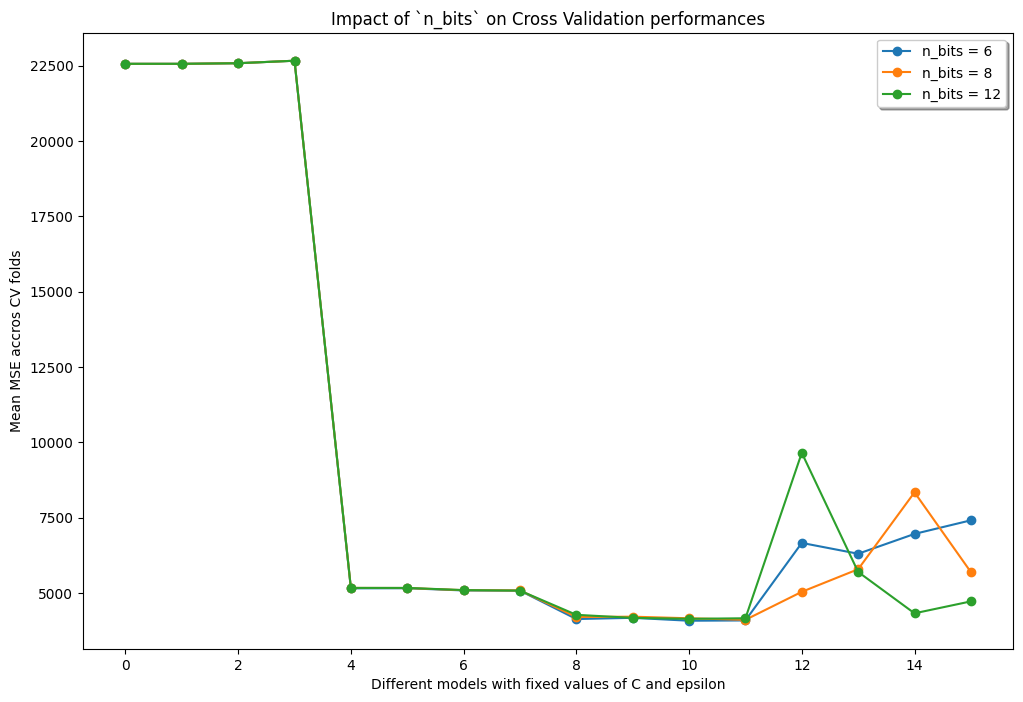

In [8]:
plt.ioff()

results_df = pd.DataFrame(gs_concrete.cv_results_)

fig, ax = plt.subplots(1, figsize=(12, 8))
(l1,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 6, "mean_test_score"], "-o"
)
(l2,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 8, "mean_test_score"], "-o"
)
(l3,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 12, "mean_test_score"], "-o"
)
ax.legend((l1, l2, l3), ("n_bits = 6", "n_bits = 8", "n_bits = 12"), loc="upper right", shadow=True)
ax.set_xlabel("Different models with fixed values of C and epsilon")
ax.set_ylabel("Mean MSE accros CV folds")
ax.set_title("Impact of `n_bits` on Cross Validation performances")
display(fig)

As seen in the graph, this fairly simple data-set has only a single feature and few points, in addition to a fairly simple model with only few parameters for the decision rule. The complexity of the information to be represented as integers is not huge. This results in `n_bits` values having less of an impact on the perfomance of the model. 

You can see that for the best model, performances with `n_bits` equal to `6`, `8` or `12` are quite close. Performances differ for models with `C = 100000.0`, meaning the `l2` penalty is weak and the decision rule can adjust more easily to the data. 

### Compare sklearn and Concrete ML Quantized best models.

#### performance.

In [9]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit sklearn: {np.mean(gs_sklearn.cv_results_['mean_fit_time']):.3f}s,"
    f" std time fit sklearn: {np.std(gs_sklearn.cv_results_['mean_fit_time']):.3f}s"
)
print(
    f"Mean time fit concrete: {np.mean(gs_concrete.cv_results_['mean_fit_time']):.3f}s,"
    f"std time fit concrete: {np.std(gs_concrete.cv_results_['mean_fit_time']):.3f}s"
)

# Print best score for both models
print(f"Best MSE score sklearn: {-gs_sklearn.best_score_:.2f}")
print(f"Best MSE score concrete: {-gs_concrete.best_score_:.2f}")

Mean time fit sklearn: 0.002s, std time fit sklearn: 0.002s
Mean time fit concrete: 0.031s,std time fit concrete: 0.002s
Best MSE score sklearn: 4083.52
Best MSE score concrete: 4080.20


#### hyperparameters.

In [10]:
# Get best hyperparameters out of gs_concrete
best_params_concrete = gs_concrete.best_params_
print(f"Best parameters for Concrete: {best_params_concrete}")
best_params_sklearn = gs_sklearn.best_params_
print(f"Best parameters for Sklearn: {best_params_sklearn}")

Best parameters for Concrete: {'C': 10000.0, 'epsilon': 10.0, 'n_bits': 6}
Best parameters for Sklearn: {'C': 10000.0, 'epsilon': 20.0}


### train with best hyperparameter set on the complete training data-set.

In [11]:
# Train concrete and sklearn LinearSVR with best hyper parameters
concrete_rgs = ConcreteLinearSVR(**best_params_concrete)

concrete_rgs, sklearn_rgs = concrete_rgs.fit_benchmark(X_train, y_train)

## Concrete ML Quantized LinearSVR with FHE

### Prerequisite.

Some prerequisites should be reviewed before you dive in.

Quantization is a technique that converts continuous data (floating point, e.g., in 32-bits) to discrete numbers within a fixed range (in our case either 6, 8, or 12 bits). This means that some information is lost during the process. However, the larger the integers' range, the smaller the error becomes, making it acceptable in some cases.

To learn more about quantization, please refer to this [documentation section](../explanations/quantization.md).

Regarding FHE, the input data type must be represented exclusively as integers, making the use of quantization necessary. A linear model trained on floats is quantized into an equivalent integer model using *Post-Training Quantization*. This operation can lead to a loss of accuracy compared to the standard floating point models working on clear data.

In practice, this loss is usually very limited with linear FHE models as they can consider very large integers with up to 50 bits in some cases. This means these models can quantize their inputs and weights over a large number of bits while still considering data-sets containing many features (e.g. 1000). We often observe almost identical performance scores between float, quantized, and FHE models.

To learn more about the relation between the maximum bit-width reached within a model, the bits of quantization used, and the data-set's number of features, please refer to this [documentation section](../explanations/pruning.md).

### Compilation.

To perform homomorphic inference, we take the above trained quantized model and we compile it to get an FHE model.

The compiler requires an exhaustive set of data to evaluate the maximum integer bit-width within the graph, which is needed during FHE computations before running any predictions.

You can either provide the entire trained data-set or a smaller but representative subset.

In [12]:
# Compile the model using the training data
circuit = concrete_rgs.compile(X_train)

### Generate the key.

The compiler returns a circuit, which can then be used for key generation and predictions. More precisely, it generates:

* a Secret Key, used for the encryption and decryption processes. This key should remain accessible only to the user.
* an Evaluation Key, used to evaluate the circuit on encrypted data. Anyone can access this key without breaching the model's security.


In [13]:
# Generate the key
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 7-bit circuit


In [14]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 0.00 seconds


### Now let's predict using the FHE model on encrypted data.

Please notice `fhe="execute"`, which creates the job under the hood: Before the data is sent to be applied to the model, it is encrypted with the client secret key, generated above. 

As for future comparison below, we also predict on the very same data on both:
* the sklearn model;
* the Concrete ML quantized model without FHE. 

In [15]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = concrete_rgs.predict(X_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using the Sklearn model on the testing set
time_begin = time.time()
y_pred_sklearn = sklearn_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using clear quantized Concrete-ML model on testing set
time_begin = time.time()
y_preds_quantized = concrete_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

Execution time: 0.0022 seconds per sample


Execution time: 0.0000 seconds per sample
Execution time: 0.0000 seconds per sample


## Compare

### Display performance spreads.

In [16]:
# Print all MSE a string to explain

mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
mse_clear = mean_squared_error(y_test, y_preds_quantized)
mse_fhe = mean_squared_error(y_test, y_pred_fhe)

print(
    f"Clear FP32 sklearn model MSE: {mse_sklearn:.3f}\n"
    f"Clear quantized model MSE: {mse_clear:.3f}\n"
    f"FHE model MSE: {mse_fhe:.3f}"
)

# Measure the error of the FHE-quantized model with respect to quantized clear Concrete ML model
concrete_score_difference = abs(mse_fhe - mse_clear) * 100 / mse_clear
print(
    "\nRelative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores:",
    f"{concrete_score_difference:.2f}%",
)


# Measure the error of the FHE quantized model with respect to the sklearn float model
score_difference = abs(mse_fhe - mse_sklearn) * 100 / mse_sklearn
print(
    "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
    f"{score_difference:.2f}%",
)

Clear FP32 sklearn model MSE: 3977.761
Clear quantized model MSE: 3932.128
FHE model MSE: 3932.128

Relative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores: 0.00%
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 1.15%


We can observe that scikit-learn and Concrete ML (quantized clear) models output **very close** scores. This demonstrates how the quantization process has a very limited impact on performances.

We can observe as well that the performance difference between Concrete ML (quantized clear) and Concrete ML (FHE) is quasi null. This demonstrates that the compilation process has a very limited impact on performance. If one observed a more significant difference, then `n_bits` can be increased to offer more degrees of freedom during the compilation process. 

### Visualize the decision rule.

In [17]:
# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_rgs.predict(x_space)

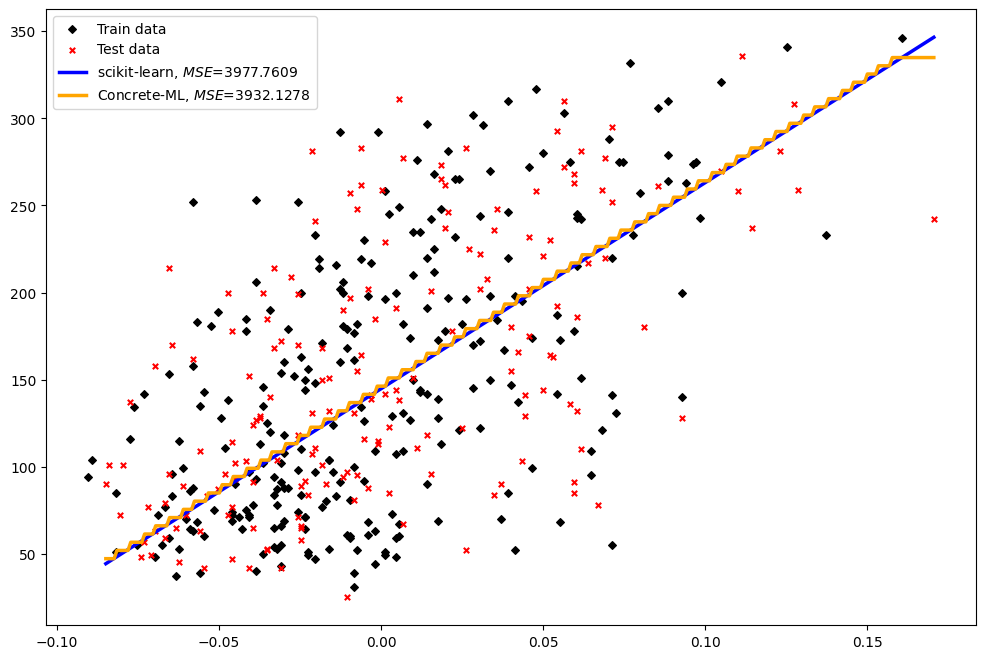

In [18]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred_sklearn, **get_sklearn_plot_config(mse_sklearn))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(mse_clear))
ax.legend()
display(fig)

In the above graph, you can see that the test data-set has a point for which `X` value is outside the range of the trained data-set. Since, when we compiled the quantized model we used `X_train`, this `X` value in the test data-set was not seen by the compilation process, the decision rule poorly generalizes on those values outside the boundaries observed on `X_tain`. An alternative to correct this would be to give at model compilation time, a wider range of values for `X`. 

## Conclusion

We have shown how easy it is to train and execute a LinearSVR regression model in FHE using Concrete ML.

We have also discussed the development flow of an FHE model: training, quantization, compilation, and inference.

Prediction performances are quasi identical. The tiny difference is explained by the quantization process and the compilation of the trained model. 